<a href="https://colab.research.google.com/github/vladimir22092400/time-series-1/blob/main/time_series_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Business analysis

### 1.1 Task:

Download the materials for the lesson.

### 1.2 Target:

Analyze the series and make them stationary.

### 1.3 Data downloading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data understanding

### 2.1 Importing libraries

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox, shapiro, normaltest
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 2.2 Helpful functions

In [3]:
def test_stationarity(timeseries, all_test=False):
  '''returns Dickey-Fuller test or p-value'''
  dftest = adfuller(timeseries, autolag='AIC')
  if all_test:
    return dftest
  else:
    return dftest[1] #p-value


def plot_acf_pacf(timeseries, figsize=(8, 6), lags=None):
  '''plot timeseries statsmodels.api.graphics.tsa plot_acf and plot_pacf'''
  fig = plt.figure(figsize=figsize)
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf(timeseries.values.squeeze(), lags=lags, ax=ax1)
  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
  plt.tight_layout()
  plt.show()


def print_test(timeseries, name):
  '''print Dickey-Fuller test result'''
  print(f'{name} Dickey-Fuller test result')
  dftest = test_stationarity(timeseries, all_test=True)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for [key, value] in dftest[4].items():
      dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)


def plot_line(data, **kwargs):
  '''plot a selected time series'''
  n_rows = kwargs.get('n_rows', 1)
  n_cols = kwargs.get('n_cols', 1)
  figsize = kwargs.get('figsize', (8, 6))
  fig = plt.figure(figsize=figsize)
  for i, key in enumerate(data.keys()):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    data.get(key).plot(ax=ax, color='blue')
    ax.set_title(key, fontsize=10)
  plt.tight_layout()
  plt.show()


def plot_hist(data, **kwargs):
  '''plot a selected time series histograms'''
  n_rows = kwargs.get('n_rows', 1)
  n_cols = kwargs.get('n_cols', 1)
  figsize = kwargs.get('figsize', (8, 6))
  fig = plt.figure(figsize=figsize)
  for i, key in enumerate(data.keys()):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    sns.histplot(x=data.get(key), bins=15, ax=ax)
    ax.set_title(key, fontsize=10)
  plt.tight_layout()
  plt.show()

### 2.3 Creating series

In [4]:
female_births = pd.read_csv("drive/My Drive/Series/daily-total-female-births-in-cal.csv")
airlines_passengers = pd.read_csv("drive/My Drive/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("drive/My Drive/Series/mean-monthly-air-temperature-deg.csv")
robberies_in_boston = pd.read_csv("drive/My Drive/Series/monthly-boston-armed-robberies-j.csv")
sales_of_company_x = pd.read_csv("drive/My Drive/Series/monthly-sales-of-company-x-jan-6.csv")
dowjones_closing = pd.read_csv("drive/My Drive/Series/weekly-closings-of-the-dowjones-.csv")

### 2.4 Series analysis

In [5]:
all_series = {
    "Daily total female births in California": female_births["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"]}

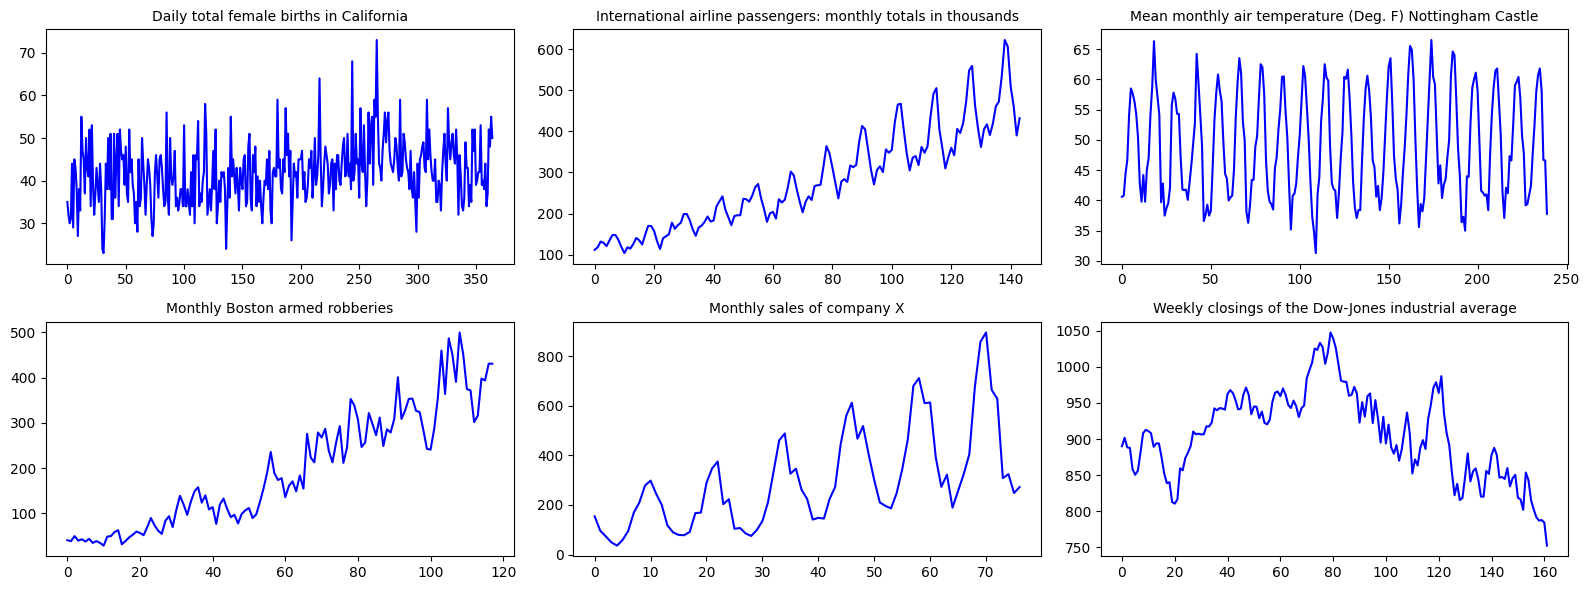

In [6]:
plot_line(all_series, n_rows=2, n_cols=3, figsize=(16, 6))

## 3. Data preparation

### 3.1 Getting Dickey-Fuller test p-value

In [7]:
transformations = dict()
lower_bound = 0.05 # lower bound for p-value
all_series_pvalue = dict()
for key in all_series.keys():
  series = all_series.get(key)
  p_value = test_stationarity(series, all_test=False)
  all_series_pvalue.update({key: p_value})
  transformations.update({key: []})

p_value_init = all_series_pvalue.copy()

### 3.2 Time series boxcox transformation

In [9]:
for key in all_series.keys():  
  series = all_series.get(key)
  p_value_prev = all_series_pvalue.get(key)
  series_probe = pd.Series(boxcox(series, 0))
  p_value = test_stationarity(series_probe, all_test=False)
  if p_value < p_value_prev:
    all_series[key] = series_probe # replaces the value of series and p_value
    all_series_pvalue[key] = p_value
    transformations[key].append('boxcox')

### 3.3 Time series trend deleting 


In [17]:
for key in all_series.keys():
  series = all_series.get(key)
  p_value_prev = all_series_pvalue.get(key)
  series_probe = pd.Series(np.diff(series))
  p_value = test_stationarity(series_probe, all_test=False)
  if p_value < p_value_prev:
    all_series[key] = series_probe # replaces the value of series and p_value
    all_series_pvalue[key] = p_value
    transformations[key].append('np.diff(lag=1)')

### 3.4 Remove seasonality 

In [19]:
for key in all_series.keys():
  series = all_series.get(key)
  p_value_prev = all_series_pvalue.get(key)
  arr_to_diff = np.array([series[:-12], series[12:]])
  series_probe = pd.Series(np.diff(arr_to_diff, axis=0)[0])
  p_value = test_stationarity(series_probe, all_test=False)
  if p_value < p_value_prev:
    all_series[key] = series_probe # replaces the value of series and p_value
    all_series_pvalue[key] = p_value
    transformations[key].append('np.diff(lag=12)')

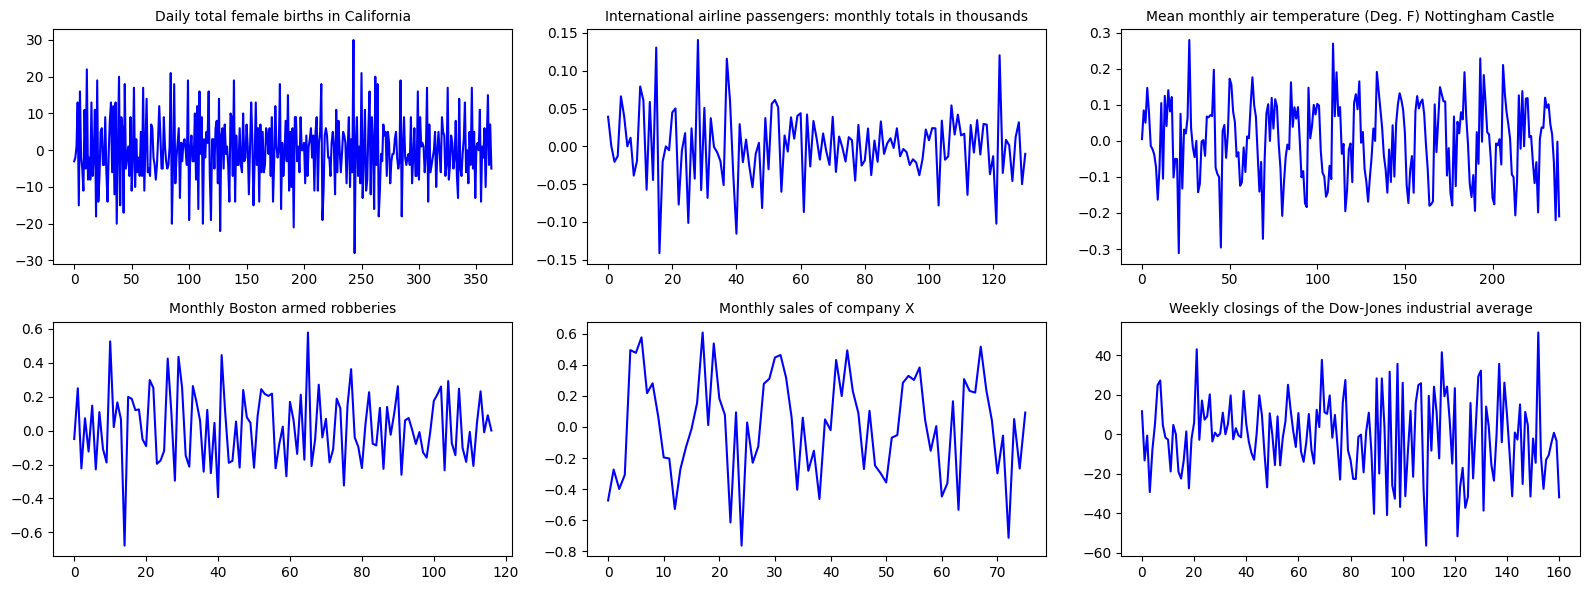

In [21]:
plot_line(all_series, n_rows=2, n_cols=3, figsize=(16, 6))

1.6407281304676633e-22


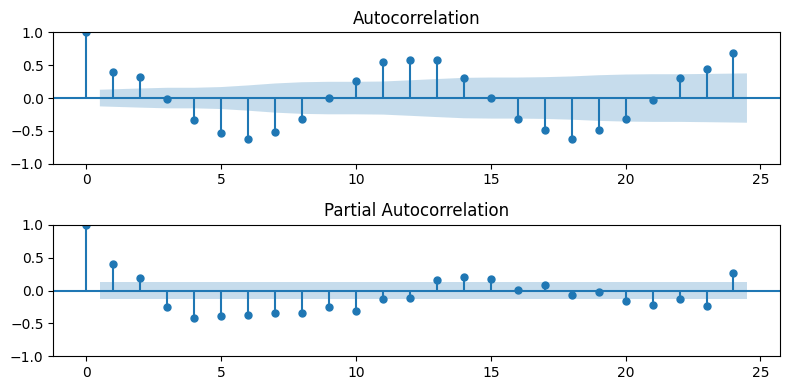

In [22]:
key = 'Mean monthly air temperature (Deg. F) Nottingham Castle'
series = all_series.get(key)
print(all_series_pvalue.get(key))
plot_acf_pacf(series, figsize=(8, 4))

Due to the very small p-value (within the statistical error), the removal of seasonality of the 'Mean monthly air temperature (Deg. F) Nottingham Castle' will be carried out manually

In [23]:
key = 'Mean monthly air temperature (Deg. F) Nottingham Castle'
series = all_series.get(key)
arr_to_diff = np.array([series[:-12], series[12:]])
all_series[key] = pd.Series(np.diff(arr_to_diff, axis=0)[0])
transformations[key].append('np.diff(lag=12)')

0.024025392839875176


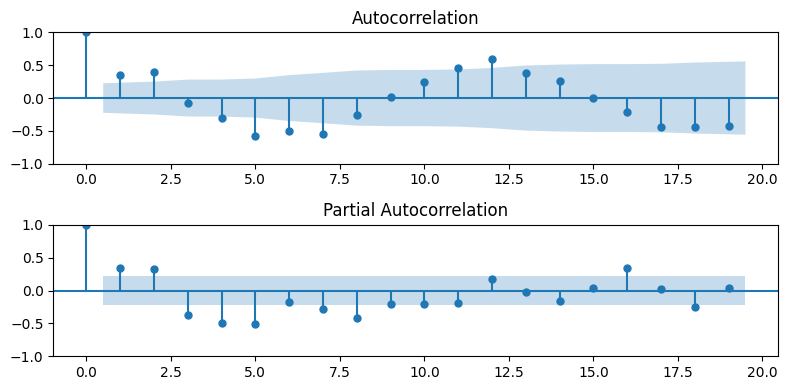

In [26]:
key = "Monthly sales of company X"
series = all_series.get(key)
print(all_series_pvalue.get(key))
plot_acf_pacf(series, figsize=(8, 4))

'Monthly sales of company X' once again differentiates

In [34]:
key = 'Monthly sales of company X'
series = all_series.get(key)
p_value_prev = all_series_pvalue.get(key)
arr_to_diff = np.array([series[:-1], series[1:]])
series_probe = pd.Series(np.diff(arr_to_diff, axis=0)[0])
p_value = test_stationarity(series_probe, all_test=False)
if p_value < p_value_prev:
  all_series[key] = series_probe # replaces the value of series and p_value
  all_series_pvalue[key] = p_value
  transformations[key].append('np.diff(lag=1)')

## 4. Data Evaluation

### 4.1 Data Visualization

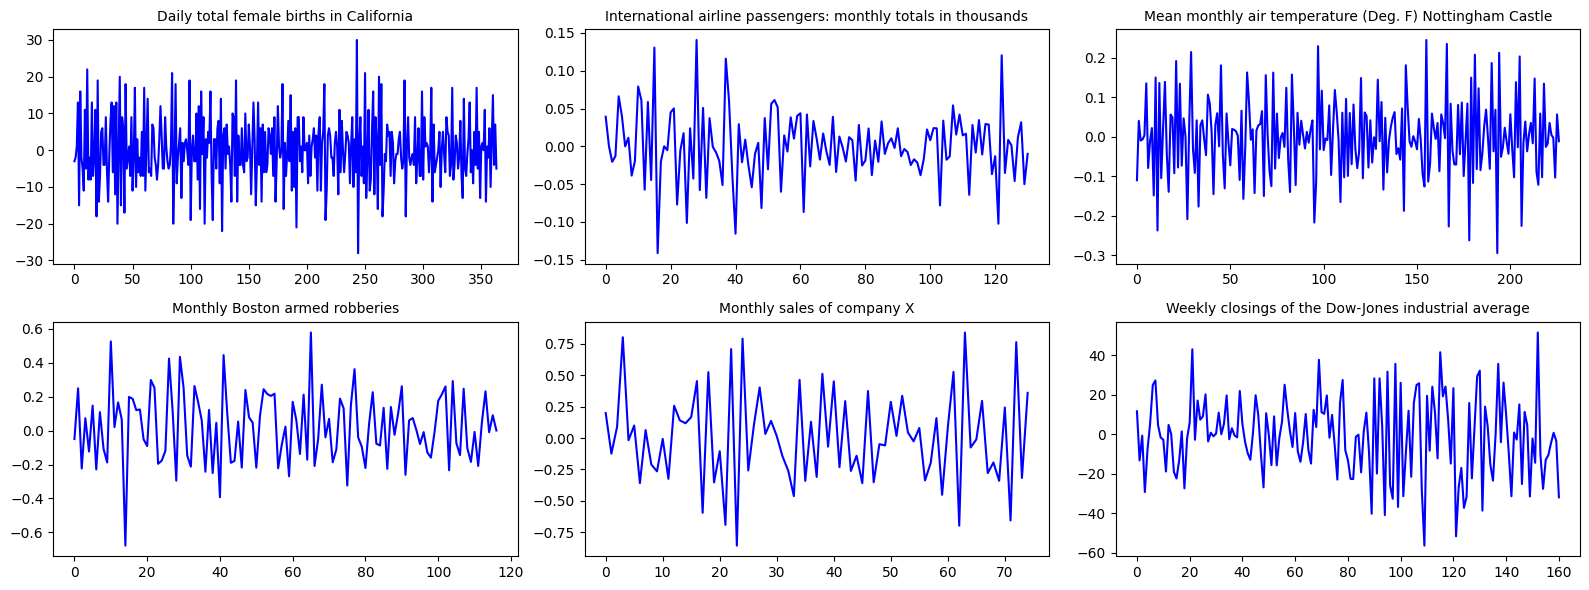

In [35]:
plot_line(all_series, n_rows=2, n_cols=3, figsize=(16, 6))

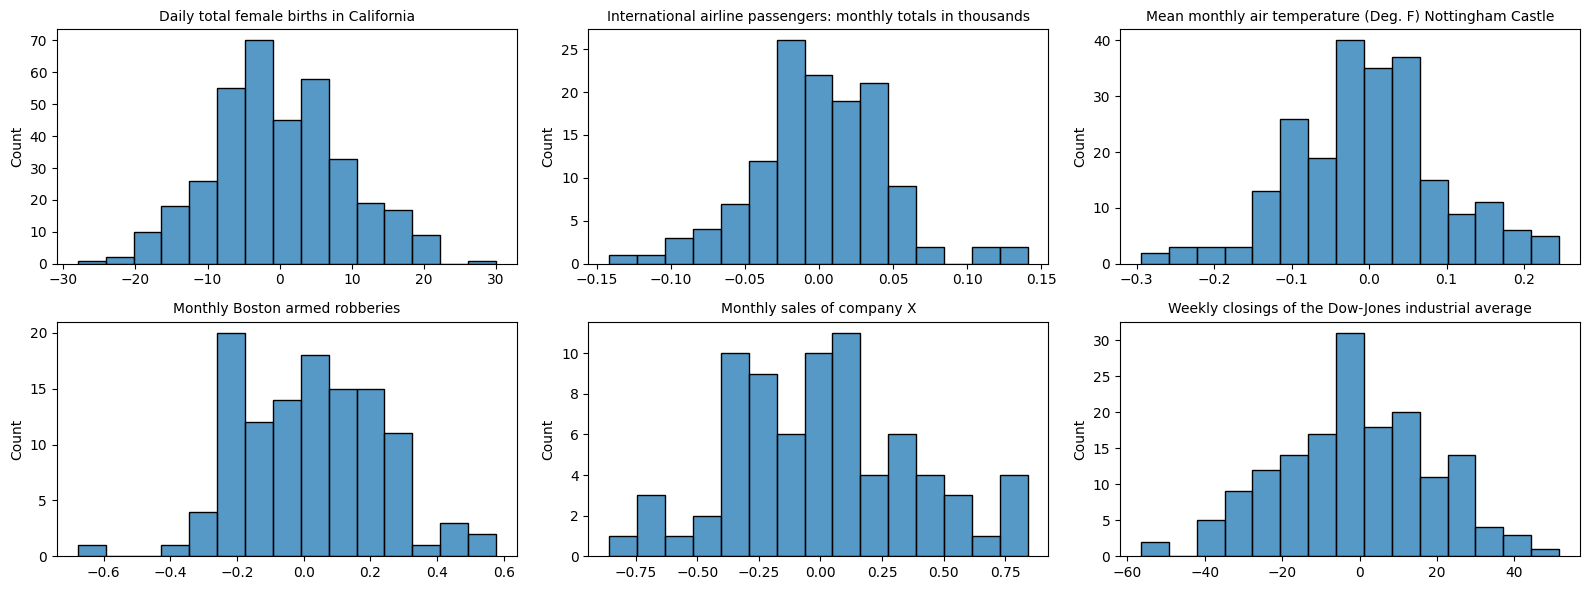

In [36]:
plot_hist(all_series, n_rows=2, n_cols=3, figsize=(16, 6))

Daily total female births in California Dickey-Fuller test result
Test Statistic                -1.262518e+01
p-value                        1.547240e-23
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


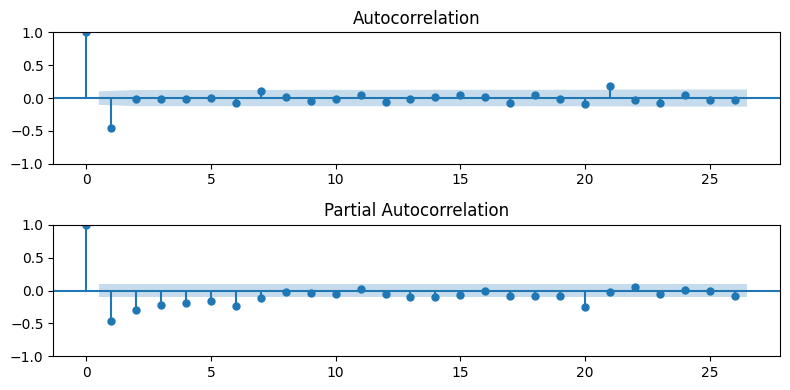

International airline passengers: monthly totals in thousands Dickey-Fuller test result
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


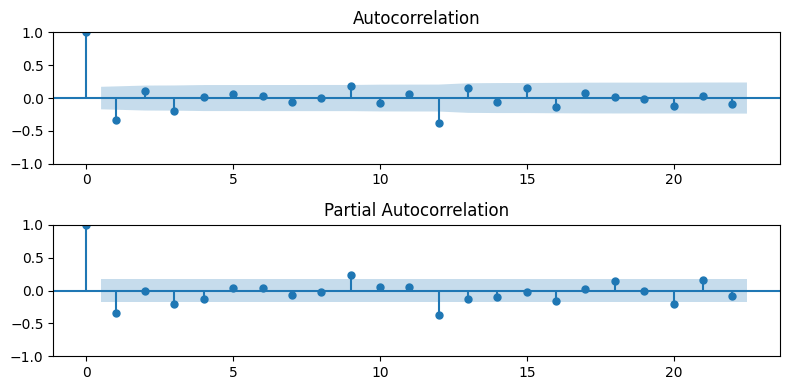

Mean monthly air temperature (Deg. F) Nottingham Castle Dickey-Fuller test result
Test Statistic                -7.999033e+00
p-value                        2.361164e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


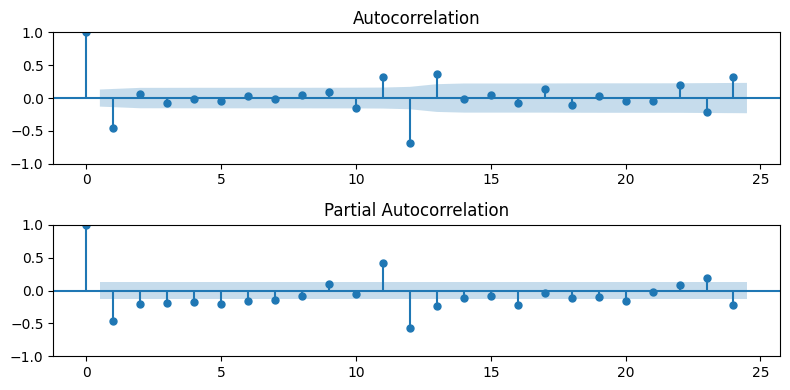

Monthly Boston armed robberies Dickey-Fuller test result
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


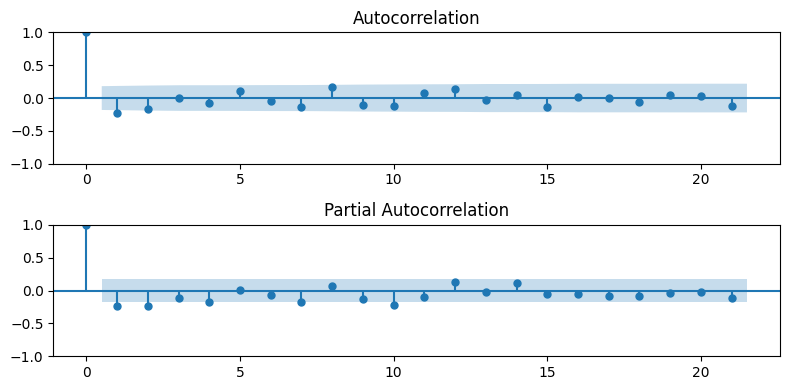

Monthly sales of company X Dickey-Fuller test result
Test Statistic                -7.101182e+00
p-value                        4.164137e-10
#Lags Used                     1.100000e+01
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64


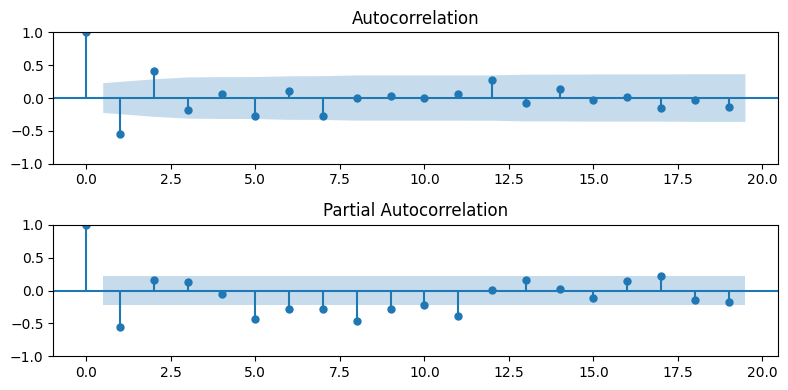

Weekly closings of the Dow-Jones industrial average Dickey-Fuller test result
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


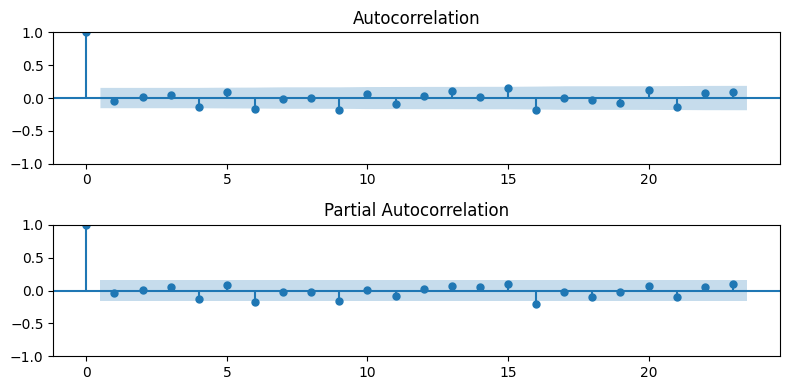

In [42]:
for key in all_series.keys():
  series = all_series.get(key)
  print_test(series, key)
  plot_acf_pacf(series, figsize=(8, 4))

### 4.2 Conducting a test for the normality of the distribution of the obtained time series

In [43]:
shapiro_pvalue = dict()
for key in all_series.keys():
  series = all_series.get(key)
  _, p_value = shapiro(series)
  shapiro_pvalue.update({key: round(p_value, 5)})

In [44]:
normaltest_pvalue = dict()
for key in all_series.keys():
  series = all_series.get(key)
  _, p_value = normaltest(series)
  normaltest_pvalue.update({key: round(p_value, 5)})

## 5. Report

### 5.1 Report creating

In [45]:
data = list(zip(transformations.values(), p_value_init.values(), all_series_pvalue.values(), shapiro_pvalue.values(), normaltest_pvalue.values()))
ind = sorted(all_series.keys())
cols = ['transformations', 'initial adfuller p-value', 'result adfuller p-value', 'shapiro p_value', 'normaltest p_value']
result = pd.DataFrame(data, index=ind, columns=cols)
result

,transformations,initial adfuller p-value,result adfuller p-value,shapiro p_value,normaltest p_value
Daily total female births in California,[np.diff(lag=1)],0.000052,1.547240e-23,0.23546,0.61191
International airline passengers: monthly totals in thousands,"[boxcox, np.diff(lag=1), np.diff(lag=12)]",0.991880,2.485912e-04,0.04918,0.07974
Mean monthly air temperature (Deg. F) Nottingham Castle,"[boxcox, np.diff(lag=1), np.diff(lag=12)]",0.016989,1.640728e-22,0.25286,0.68924
Monthly Boston armed robberies,"[boxcox, np.diff(lag=1)]",0.994278,2.378602e-11,0.12342,0.68847
Monthly sales of company X,"[boxcox, np.diff(lag=1), np.diff(lag=1)]",0.988889,4.164137e-10,0.53576,0.77516
Weekly closings of the Dow-Jones industrial average,[np.diff(lag=1)],0.622455,2.407586e-24,0.92912,0.87778


### 5.2 Report saving

In [46]:
result.to_csv('report.csv')